# Revenue Prediction Model - Development Notebook

## Objetivo
Desarrollar un modelo predictivo para inferir el revenue generado por un usuario en los primeros 7 días desde la instalación.

## Contenido
1. Carga y exploración de datos (EDA)
2. Feature Engineering
3. Modelado y evaluación
4. Selección del modelo final
5. Exportación del modelo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('Librerías cargadas correctamente')

Librerías cargadas correctamente


## 1. Carga y Exploración de Datos

In [2]:
# Cargar dataset
df = pd.read_csv('../data/dataset.csv')

print(f'Dataset shape: {df.shape}')
print(f'\nPrimeras filas:')
df.head(10)

Dataset shape: (20000, 11)

Primeras filas:


,user_id,country,country_region,source,platform,device_family,os_version,event_1,event_2,event_3,revenue
0,a62c86b4,cr,Provincia de San Jose,Organic,iOS,Apple iPhone,14.4,0,102,0.0,0.317348
1,1d5189a4,ie,Leinster,Organic,Android,Samsung Galaxy Phone,8.0.0,0,32,NaN,0.105701
2,9a2ad63a,uy,Departamento de Montevideo,Organic,Android,samsung samsung SM-A107M,10,0,4,0.0,0.003268
3,e1b19bfd,ar,Buenos Aires,Organic,ios,Apple iPad,12.5.1,0,117,0.0,0.180275
4,312293d4,es,Valencia,Organic,iOS,Apple iPhone,12.5.1,0,57,1.0,0.133304
5,bfac9480,es,Madrid,Organic,iOS,Apple iPhone,14.4,0,6,0.0,0.014673
6,9fa3ce41,es,Las Palmas,Organic,iOS,Apple iPhone,14.4,0,295,0.0,0.721179
7,c2e0d65c,es,Valencia,Organic,iOS,Apple iPhone,14.4,0,135,0.0,0.334883
8,f532f897,es,Seville,Organic,iOS,Apple iPad,10.3.3,0,12,0.0,0.029475
9,e7cc045d,es,Seville,Organic,iOS,"Apple iPad11,6",14.4,0,292,4.0,0.724194


In [3]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         20000 non-null  object 
 1   country         20000 non-null  object 
 2   country_region  19366 non-null  object 
 3   source          19183 non-null  object 
 4   platform        20000 non-null  object 
 5   device_family   19999 non-null  object 
 6   os_version      19999 non-null  object 
 7   event_1         20000 non-null  int64  
 8   event_2         20000 non-null  int64  
 9   event_3         19601 non-null  float64
 10  revenue         20000 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.7+ MB


In [4]:
# Estadísticas descriptivas
df.describe()

,event_1,event_2,event_3,revenue
count,20000.000000,20000.000000,19601.000000,20000.000000
mean,3.019350,53.023500,3.994439,29.596330
std,72.631306,119.469538,18.325468,849.034984
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.000000,0.000000,0.011876
75%,0.000000,53.000000,1.000000,0.117044
max,4879.000000,2694.000000,643.000000,68838.563100


In [5]:
# Verificar valores nulos
print('Valores nulos por columna:')
null_counts = df.isnull().sum()
null_pcts = (null_counts / len(df)) * 100
null_df = pd.DataFrame({
    'null_count': null_counts,
    'null_pct': null_pcts
})
null_df[null_df['null_count'] > 0]

Valores nulos por columna:


,null_count,null_pct
country_region,634,3.170
source,817,4.085
device_family,1,0.005
os_version,1,0.005
event_3,399,1.995


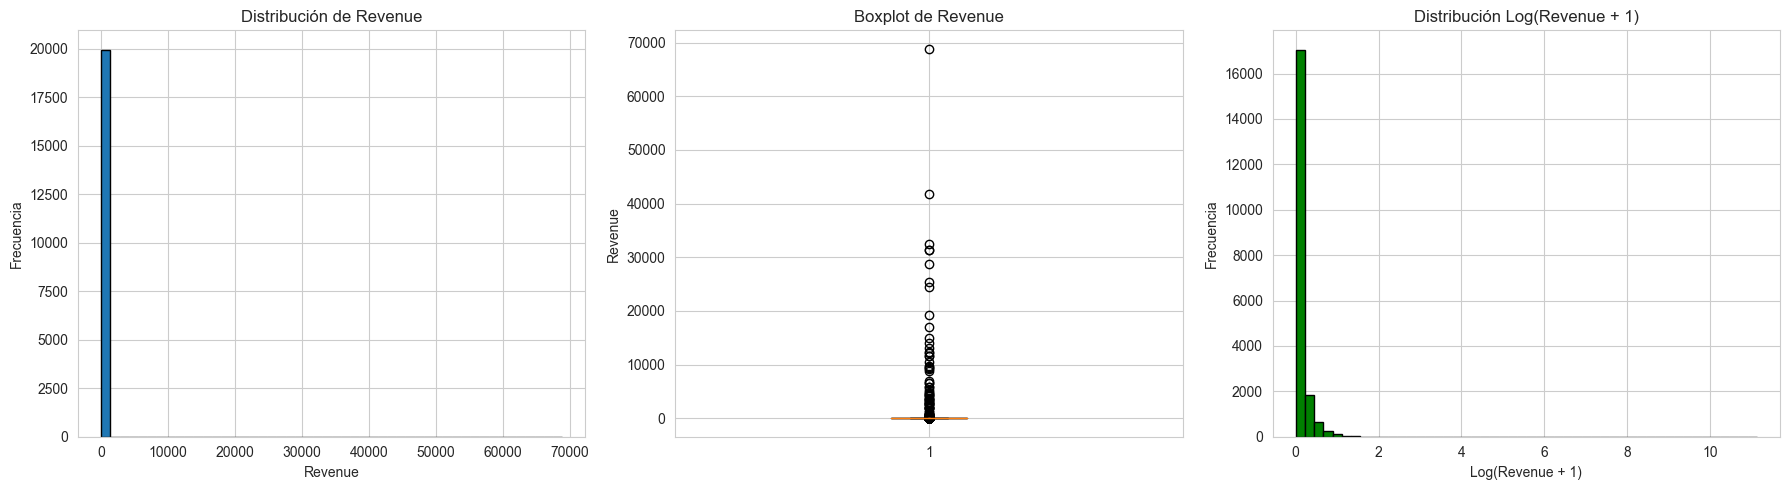

Media: 29.5963
Mediana: 0.0119
Std: 849.0350
Min: 0.0000
Max: 68838.5631


In [6]:
# Distribución de la variable target (revenue)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma
axes[0].hist(df['revenue'], bins=50, edgecolor='black')
axes[0].set_title('Distribución de Revenue')
axes[0].set_xlabel('Revenue')
axes[0].set_ylabel('Frecuencia')

# Boxplot
axes[1].boxplot(df['revenue'])
axes[1].set_title('Boxplot de Revenue')
axes[1].set_ylabel('Revenue')

# Log distribution
axes[2].hist(np.log1p(df['revenue']), bins=50, edgecolor='black', color='green')
axes[2].set_title('Distribución Log(Revenue + 1)')
axes[2].set_xlabel('Log(Revenue + 1)')
axes[2].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print(f'Media: {df["revenue"].mean():.4f}')
print(f'Mediana: {df["revenue"].median():.4f}')
print(f'Std: {df["revenue"].std():.4f}')
print(f'Min: {df["revenue"].min():.4f}')
print(f'Max: {df["revenue"].max():.4f}')

In [7]:
# Análisis de variables categóricas
categorical_cols = ['country', 'country_region', 'source', 'platform', 'device_family', 'os_version']

for col in categorical_cols:
    print(f'\n{col.upper()}:')
    print(f'Valores únicos: {df[col].nunique()}')
    print(f'Top 10 valores:')
    print(df[col].value_counts().head(10))


COUNTRY:
Valores únicos: 91
Top 10 valores:
country
es    12892
fr     3310
mx      840
ar      497
us      299
co      254
it      253
de      168
br      158
ca      135
Name: count, dtype: int64

COUNTRY_REGION:
Valores únicos: 680
Top 10 valores:
country_region
Madrid         2869
Barcelona      2203
Valencia       1097
Seville         723
Malaga          357
Mexico City     340
Paris           315
Alicante        309
Biscay          267
Murcia          258
Name: count, dtype: int64

SOURCE:
Valores únicos: 2
Top 10 valores:
source
Organic        14391
Non-Organic     4792
Name: count, dtype: int64

PLATFORM:
Valores únicos: 4
Top 10 valores:
platform
Android    12169
iOS         6803
android      643
ios          385
Name: count, dtype: int64

DEVICE_FAMILY:
Valores únicos: 982
Top 10 valores:
device_family
Apple iPhone                     5621
Samsung Galaxy Phone             3137
Huawei Phone                     1513
Xiaomi Phone                     1316
Apple iPad             

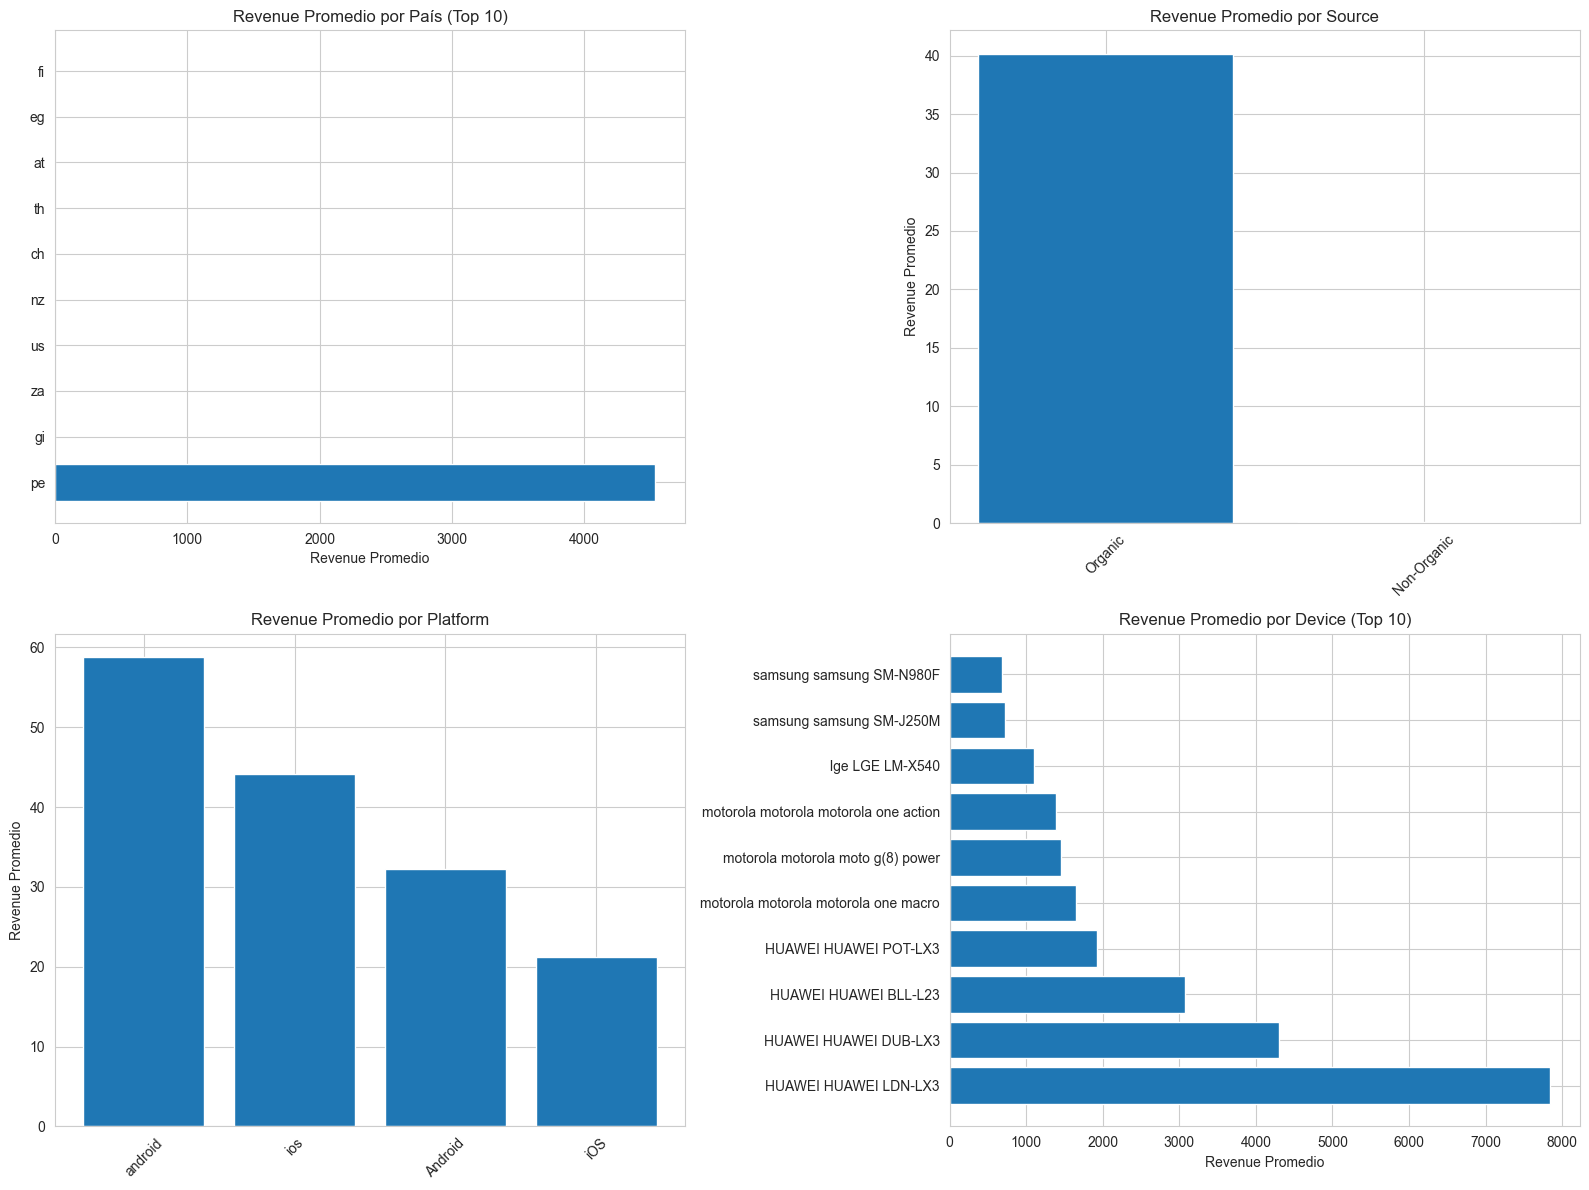

In [8]:
# Revenue promedio por categorías principales
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Por país (top 10)
top_countries = df.groupby('country')['revenue'].mean().sort_values(ascending=False).head(10)
axes[0, 0].barh(range(len(top_countries)), top_countries.values)
axes[0, 0].set_yticks(range(len(top_countries)))
axes[0, 0].set_yticklabels(top_countries.index)
axes[0, 0].set_title('Revenue Promedio por País (Top 10)')
axes[0, 0].set_xlabel('Revenue Promedio')

# Por source
source_rev = df.groupby('source')['revenue'].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(source_rev)), source_rev.values)
axes[0, 1].set_xticks(range(len(source_rev)))
axes[0, 1].set_xticklabels(source_rev.index, rotation=45)
axes[0, 1].set_title('Revenue Promedio por Source')
axes[0, 1].set_ylabel('Revenue Promedio')

# Por platform
platform_rev = df.groupby('platform')['revenue'].mean().sort_values(ascending=False)
axes[1, 0].bar(range(len(platform_rev)), platform_rev.values)
axes[1, 0].set_xticks(range(len(platform_rev)))
axes[1, 0].set_xticklabels(platform_rev.index, rotation=45)
axes[1, 0].set_title('Revenue Promedio por Platform')
axes[1, 0].set_ylabel('Revenue Promedio')

# Por device_family (top 10)
top_devices = df.groupby('device_family')['revenue'].mean().sort_values(ascending=False).head(10)
axes[1, 1].barh(range(len(top_devices)), top_devices.values)
axes[1, 1].set_yticks(range(len(top_devices)))
axes[1, 1].set_yticklabels(top_devices.index)
axes[1, 1].set_title('Revenue Promedio por Device (Top 10)')
axes[1, 1].set_xlabel('Revenue Promedio')

plt.tight_layout()
plt.show()

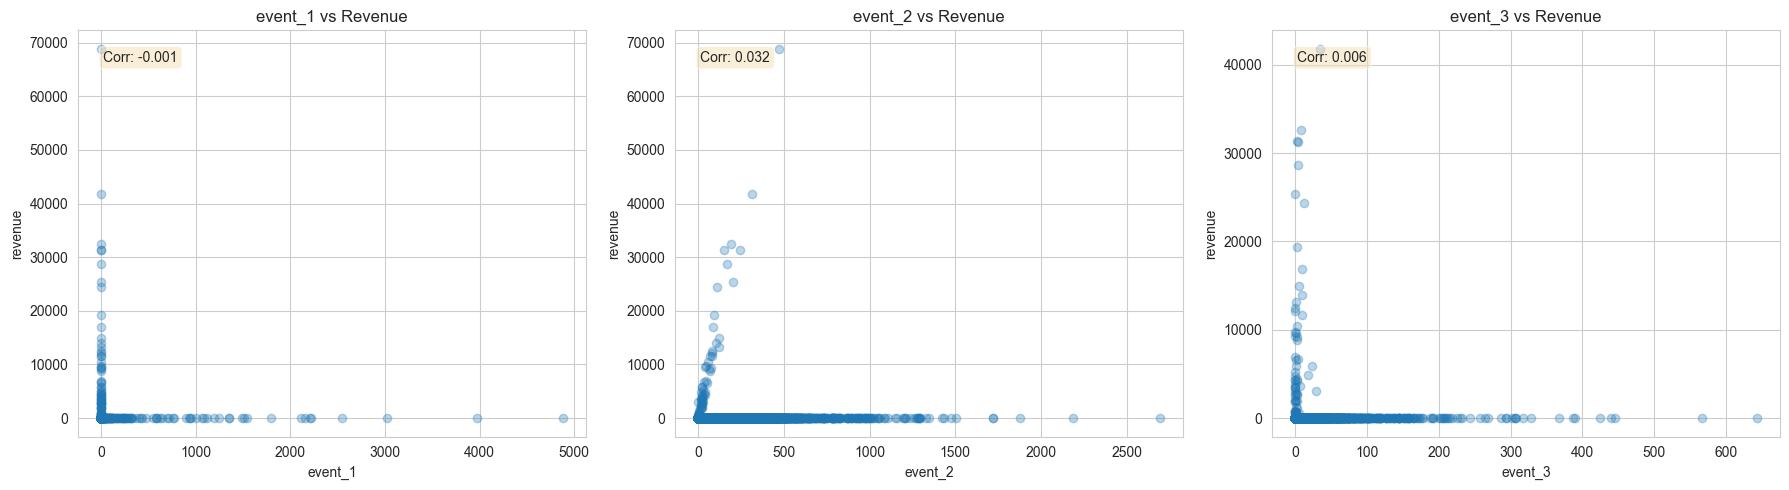


Estadísticas de eventos:


,event_1,event_2,event_3
count,20000.000000,20000.000000,19601.000000
mean,3.019350,53.023500,3.994439
std,72.631306,119.469538,18.325468
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,5.000000,0.000000
75%,0.000000,53.000000,1.000000
max,4879.000000,2694.000000,643.000000


In [9]:
# Análisis de variables numéricas (eventos)
event_cols = ['event_1', 'event_2', 'event_3']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(event_cols):
    axes[i].scatter(df[col], df['revenue'], alpha=0.3)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('revenue')
    axes[i].set_title(f'{col} vs Revenue')
    
    # Calcular correlación
    corr = df[[col, 'revenue']].corr().iloc[0, 1]
    axes[i].text(0.05, 0.95, f'Corr: {corr:.3f}', 
                transform=axes[i].transAxes, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Estadísticas de eventos
print('\nEstadísticas de eventos:')
df[event_cols].describe()

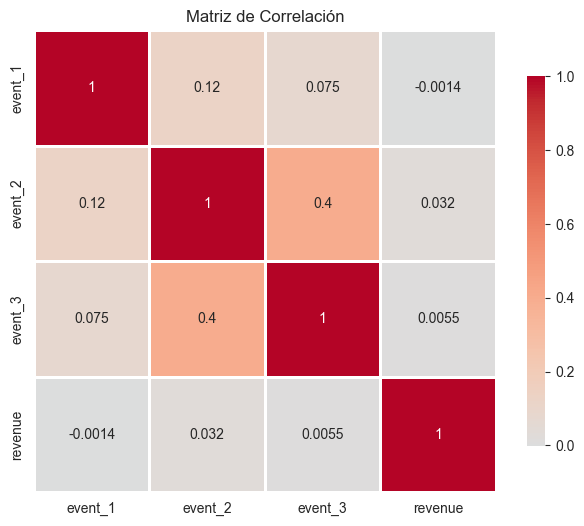

In [10]:
# Matriz de correlación
numeric_df = df[event_cols + ['revenue']].copy()
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación')
plt.show()